In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

## Da fare
1. Car model classification:
   - entire car images vs **car parts**
   - specific viewpoint vs all viewpoints
2. **Car make classification**
3. **Attribute Prediction:**
   - Sum of square loss for continuous attributes
   - Logistic loss for for discrete attributes
   - Trained of the first set and tested on the second 

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
import importlib
from pathlib import Path
import re

from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d
from torch.nn import SiLU as ReLU
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torchvision.transforms import Compose, Normalize, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Resize
import torch

from dataset import *
from utils import *
from ResNet18_blocks import *
from ResNet50_blocks import *
from training_functions import *

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Neural Network and Deep Learning Project

*Alberto Salvador, Volpi Gaia*



In [3]:
#volume_dir = "/mnt/shared_volume/"
volume_dir = "/mnt/home/u0053/disk/gaia_dataset/CompCars/"

In [4]:
! ls /mnt/shared_volume/data/train_test_split/classification

ls: cannot access '/mnt/shared_volume/data/train_test_split/classification': No such file or directory


## 1. Dataset

Qui sotto si crea il dataset per fare il training su tutti i viewpoints!!

In [5]:
label_to_index = indexing_labels(volume_dir+"data/train_test_split/classification/train.txt")
print("Nr of models in the train dataset: ", len(label_to_index))

Nr of models in the train dataset:  431


In [6]:
transforms_train = Compose([
    Resize((224, 224)), 
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    Normalize(mean=[0.485, 0.456, 0.406],
              std =[0.229, 0.224, 0.225]) #These are the ImageNet normalization values. Without them, predictions may be wrong because pretrained weights expect these stats.
])

transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std =[0.229, 0.224, 0.225])
])

In [7]:
make_dataset = dataset_factory(volume_dir, label_to_index, transforms_train, transforms) # serve per creare la factory che genera i dataset
VIEWPOINT = None
train_dataset, test_dataset, valid_dataset =  make_dataset(VIEWPOINT) # carino perchè devi passare solo il viewpoint

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].

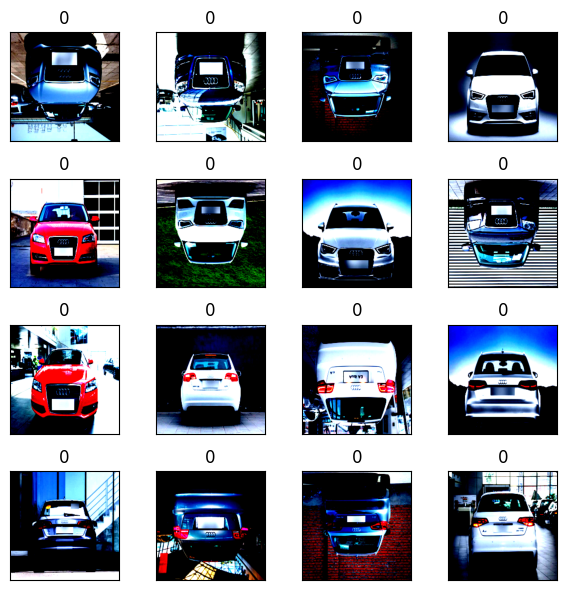

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"{train_dataset[i][1]}")
plt.tight_layout()

In [9]:
print(f'train dataset: {len(train_dataset)} \ntest dataset: {len(test_dataset)} \nvalid dataset: {len(valid_dataset)}')

train dataset: 16016 
test dataset: 7576 
valid dataset: 7363


In [10]:
# Here we use the Dataloader function from pytorch to opportunely split the dataset in batches and shuffling data
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())

In [11]:
#class weights
# labels_array = []
# for batch in train_dataloader:
#     _, labels = batch
#     labels_array.append(labels)
# labels_array = torch.cat(labels_array).numpy().astype(int)
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_array), y=labels_array)

In [12]:
#check_unbalance_dataset(valid_dataloader, n_indices=3000, title='validation set')

In [13]:
#check_unbalance_dataset(train_dataloader, n_indices=3000, title='training set')

In [14]:
#check_unbalance_dataset(valid_dataloader, n_indices=3000, title='valid set')

## 2. Training 

We have implemented two different architectures:
- ResNet50
- ResNet 18

We will proceed with ResNet18 now!

In [19]:
from torchvision.models import resnet18, ResNet18_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"

#pretrained model from torch
weights = ResNet18_Weights.DEFAULT
model_fn = lambda: resnet18(weights)
model = model_fn()
# Replace final fully connected layer to match your 431 classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 431)


loss = CrossEntropyLoss
epochs = 50

#optimizer = Adam(params=model.parameters(), lr=3e-4, weight_decay=5e-4)

/mnt/home/u0053/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


### 2.1 Training on all viewpoints
when: vp=None or '0'

Epoch: 1


100%|██████████| 39/39 [00:07<00:00,  5.33it/s]


loss: 4.703581809997559, accuracy: 0.09452668577432632
Model and optimizer state saved.
Epoch: 2


100%|██████████| 39/39 [00:07<00:00,  5.52it/s]


loss: 3.754093647003174, accuracy: 0.202634796500206
Model and optimizer state saved.
Epoch: 3


100%|██████████| 39/39 [00:07<00:00,  5.54it/s]


loss: 3.0398292541503906, accuracy: 0.32459595799446106
Model and optimizer state saved.
Epoch: 4


100%|██████████| 39/39 [00:06<00:00,  5.58it/s]


loss: 2.342024326324463, accuracy: 0.43542033433914185
Model and optimizer state saved.
Epoch: 5


100%|██████████| 39/39 [00:06<00:00,  5.61it/s]


loss: 2.014585018157959, accuracy: 0.5063153505325317
Model and optimizer state saved.
Epoch: 6


100%|██████████| 39/39 [00:07<00:00,  5.52it/s]


loss: 1.734926700592041, accuracy: 0.5727285146713257
Model and optimizer state saved.
Epoch: 7


100%|██████████| 39/39 [00:06<00:00,  5.67it/s]


loss: 1.5290465354919434, accuracy: 0.6117071509361267
Model and optimizer state saved.
Epoch: 8


100%|██████████| 39/39 [00:07<00:00,  5.39it/s]


loss: 1.4290668964385986, accuracy: 0.6333016157150269
Model and optimizer state saved.
Epoch: 9


100%|██████████| 39/39 [00:07<00:00,  5.47it/s]


loss: 1.3299798965454102, accuracy: 0.6648105382919312
Model and optimizer state saved.
Epoch: 10


100%|██████████| 39/39 [00:06<00:00,  5.61it/s]


loss: 1.2471271753311157, accuracy: 0.6801575422286987
Model and optimizer state saved.
Epoch: 11


100%|██████████| 39/39 [00:06<00:00,  5.58it/s]


loss: 1.1474132537841797, accuracy: 0.7094933986663818
Model and optimizer state saved.
Epoch: 12


100%|██████████| 39/39 [00:06<00:00,  5.81it/s]


loss: 1.1807639598846436, accuracy: 0.7012087106704712
Epoch: 13


100%|██████████| 39/39 [00:07<00:00,  5.50it/s]


loss: 1.258392095565796, accuracy: 0.6870840787887573
Epoch: 14


100%|██████████| 39/39 [00:07<00:00,  5.45it/s]


loss: 1.2531769275665283, accuracy: 0.6787993907928467
Epoch: 15


100%|██████████| 39/39 [00:06<00:00,  5.69it/s]


loss: 1.1547387838363647, accuracy: 0.7118022441864014
Epoch: 16


100%|██████████| 39/39 [00:07<00:00,  5.55it/s]


loss: 1.4446876049041748, accuracy: 0.6349313855171204
Epoch: 17


100%|██████████| 39/39 [00:07<00:00,  5.54it/s]


loss: 1.8659920692443848, accuracy: 0.5499117374420166
Epoch: 18


100%|██████████| 39/39 [00:06<00:00,  5.58it/s]


loss: 1.2991670370101929, accuracy: 0.6707863807678223
Epoch: 19


100%|██████████| 39/39 [00:06<00:00,  5.85it/s]


loss: 1.2333829402923584, accuracy: 0.6820589303970337
Epoch: 20


100%|██████████| 39/39 [00:06<00:00,  5.73it/s]


loss: 1.1154839992523193, accuracy: 0.7176422476768494
Model and optimizer state saved.
Epoch: 21


100%|██████████| 39/39 [00:06<00:00,  5.72it/s]


loss: 1.5110654830932617, accuracy: 0.6297704577445984
Epoch: 22


100%|██████████| 39/39 [00:06<00:00,  5.61it/s]


loss: 1.6790395975112915, accuracy: 0.5928289890289307
Epoch: 23


100%|██████████| 39/39 [00:06<00:00,  5.77it/s]


loss: 1.370186448097229, accuracy: 0.6623658537864685
Epoch: 24


100%|██████████| 39/39 [00:06<00:00,  5.75it/s]


loss: 1.1330887079238892, accuracy: 0.716148316860199
Epoch: 25


100%|██████████| 39/39 [00:06<00:00,  5.74it/s]


loss: 0.9864338636398315, accuracy: 0.7502376437187195
Model and optimizer state saved.
Epoch: 26


100%|██████████| 39/39 [00:06<00:00,  5.61it/s]


loss: 1.1269043684005737, accuracy: 0.727828323841095
Epoch: 27


100%|██████████| 39/39 [00:06<00:00,  5.61it/s]


loss: 1.3887406587600708, accuracy: 0.6629091501235962
Epoch: 28


100%|██████████| 39/39 [00:06<00:00,  5.64it/s]


loss: 2.7079598903656006, accuracy: 0.4154556393623352
Epoch: 29


100%|██████████| 39/39 [00:07<00:00,  5.45it/s]


loss: 1.2499256134033203, accuracy: 0.6884421706199646
Epoch: 30


100%|██████████| 39/39 [00:06<00:00,  5.62it/s]


loss: 0.96819669008255, accuracy: 0.7556702494621277
Model and optimizer state saved.
Epoch: 31


100%|██████████| 39/39 [00:06<00:00,  5.71it/s]


loss: 1.0268828868865967, accuracy: 0.7439901828765869
Epoch: 32


100%|██████████| 39/39 [00:06<00:00,  5.86it/s]


loss: 0.8632888793945312, accuracy: 0.7874507308006287
Model and optimizer state saved.
Epoch: 33


100%|██████████| 39/39 [00:06<00:00,  5.82it/s]


loss: 0.9577243328094482, accuracy: 0.764226496219635
Epoch: 34


100%|██████████| 39/39 [00:06<00:00,  5.64it/s]


loss: 1.3835383653640747, accuracy: 0.6661686897277832
Epoch: 35


100%|██████████| 39/39 [00:06<00:00,  5.88it/s]


loss: 1.6774256229400635, accuracy: 0.6041015982627869
Epoch: 36


100%|██████████| 39/39 [00:06<00:00,  5.65it/s]


loss: 1.2194249629974365, accuracy: 0.7059622406959534
Epoch: 37


100%|██████████| 39/39 [00:06<00:00,  5.83it/s]


loss: 1.01919686794281, accuracy: 0.7510525584220886
Epoch: 38


100%|██████████| 39/39 [00:06<00:00,  5.65it/s]


loss: 1.20915687084198, accuracy: 0.7082710862159729
Epoch: 39


100%|██████████| 39/39 [00:06<00:00,  5.70it/s]


loss: 1.088352084159851, accuracy: 0.7346190214157104
Epoch: 40


100%|██████████| 39/39 [00:07<00:00,  5.57it/s]


loss: 1.0783900022506714, accuracy: 0.7320385575294495
Epoch: 41


100%|██████████| 39/39 [00:07<00:00,  5.34it/s]


loss: 0.9753097891807556, accuracy: 0.7612386345863342
Epoch: 42


100%|██████████| 39/39 [00:06<00:00,  5.69it/s]


loss: 1.0224710702896118, accuracy: 0.7524107098579407
Epoch: 43


100%|██████████| 39/39 [00:07<00:00,  5.57it/s]


loss: 2.2615160942077637, accuracy: 0.49680835008621216
Epoch: 44


100%|██████████| 39/39 [00:07<00:00,  5.24it/s]


loss: 1.4254980087280273, accuracy: 0.6524514555931091
Epoch: 45


100%|██████████| 39/39 [00:07<00:00,  5.42it/s]


loss: 1.0050313472747803, accuracy: 0.745348334312439
Epoch: 46


100%|██████████| 39/39 [00:06<00:00,  5.87it/s]


loss: 1.0667170286178589, accuracy: 0.7320385575294495
Epoch: 47


100%|██████████| 39/39 [00:07<00:00,  5.34it/s]


loss: 0.9879311919212341, accuracy: 0.7548553347587585
Epoch: 48


100%|██████████| 39/39 [00:07<00:00,  5.51it/s]


loss: 1.2470990419387817, accuracy: 0.7075920104980469
Epoch: 49


100%|██████████| 39/39 [00:07<00:00,  5.36it/s]


loss: 1.538738489151001, accuracy: 0.639277458190918
Epoch: 50


100%|██████████| 39/39 [00:07<00:00,  5.36it/s]


loss: 1.282863736152649, accuracy: 0.6857259273529053


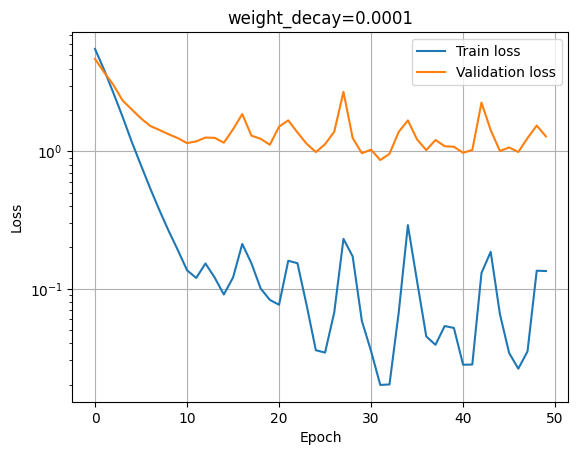

In [20]:
#weight_decays = [1e-5, 1e-4, 5e-4]
wd = 0.0001
train_loss_log, val_loss_log, _ = network_training(
train_dataloader=train_dataloader, 
valid_dataloader=valid_dataloader,
load_checkpoint=load_checkpoint(
    load=False, 
    model=model,
    opt=Adam(params=model.parameters(), lr=3e-4, weight_decay=wd), 
    device=device, 
    volume_dir=volume_dir
),
loss_fn=fix_losses(calcul_class_weights(train_dataloader), CrossEntropyLoss, device),
device=device,
epochs=epochs,
save_checkpoint=lambda model, opt: save_checkpoint(model, opt, VIEWPOINT or "0", volume_dir),
save_metric=lambda metric, values: store_metric(volume_dir)(metric, values, VIEWPOINT)
)

fig, ax = plot_losses(train_loss_log, val_loss_log, save=True)
ax.set_title(f"weight_decay={wd}")
plt.savefig(volume_dir + "gridsearch/"+f"losses_wd{wd}_pretrained.png")

In [ ]:
train_loss_log = np.loadtxt(volume_dir+str(VIEWPOINT or '0')+'/train_loss_log.txt').tolist()
val_loss_log = np.loadtxt(volume_dir+str(VIEWPOINT or '0')+'/val_loss_log.txt').tolist()
plot_losses(train_loss_log, val_loss_log)

In [12]:
torch.save(model.state_dict(), volume_dir+'0'+"/model_2.pt") 